In [1]:
import numpy as np
import cv2 as cv
from skimage.morphology import skeletonize
import glob
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from PIL import Image
import sknw
import networkx as nx
import random
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
data = pd.read_excel("data.xlsx")

In [11]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [33]:
df = pd.DataFrame(columns=["year", "radius", "length"])

y = 4248
x = 5078

for a in tqdm.tqdm(glob.glob("skeletons/*.png")):
    #Read skeleton and transform it into a graph
    ark = a[10:-7]
    im = cv.imread(a, cv.IMREAD_GRAYSCALE).astype(np.uint16)
    year = data[data.ark == "12148_"+ark].date.values[0]
    if year != year:
        continue
    for radius in range(200,5001,300):
        
        h, w = im.shape[:2]
        mask = create_circular_mask(h, w, (x,y), radius)
        masked_img = im.copy()
        masked_img[~mask] = 0
        length = np.sum(masked_img)
        df = df.append({"radius":radius*1.19, "length":length*1.19, "year":year}, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [52:31<00:00,  9.11s/it]


In [34]:
groups = np.percentile(df.year, range(10,101,10))

In [35]:
def divide_in_groups(year):
    i = 0
    while year > groups[i]:
        i+=1
    return i

In [36]:
df["group"] = df.year.apply(divide_in_groups)
df = df.sort_values(by="group")

In [39]:
df["km"] = df.length.apply(lambda m : m/1000)

In [50]:
df.group = df.group.replace(to_replace=1, value="1830-1840")
df.group = df.group.replace(to_replace=2, value="1840-1842")
df.group = df.group.replace(to_replace=3, value="1842-1846")
df.group = df.group.replace(to_replace=4, value="1846-1852")
df.group = df.group.replace(to_replace=5, value="1852-1862")
df.group = df.group.replace(to_replace=6, value="1862-1877")
df.group = df.group.replace(to_replace=7, value="1877-1889")
df.group = df.group.replace(to_replace=8, value="1889-1907")

Text(0, 0.5, 'Road network length (kilometers)')

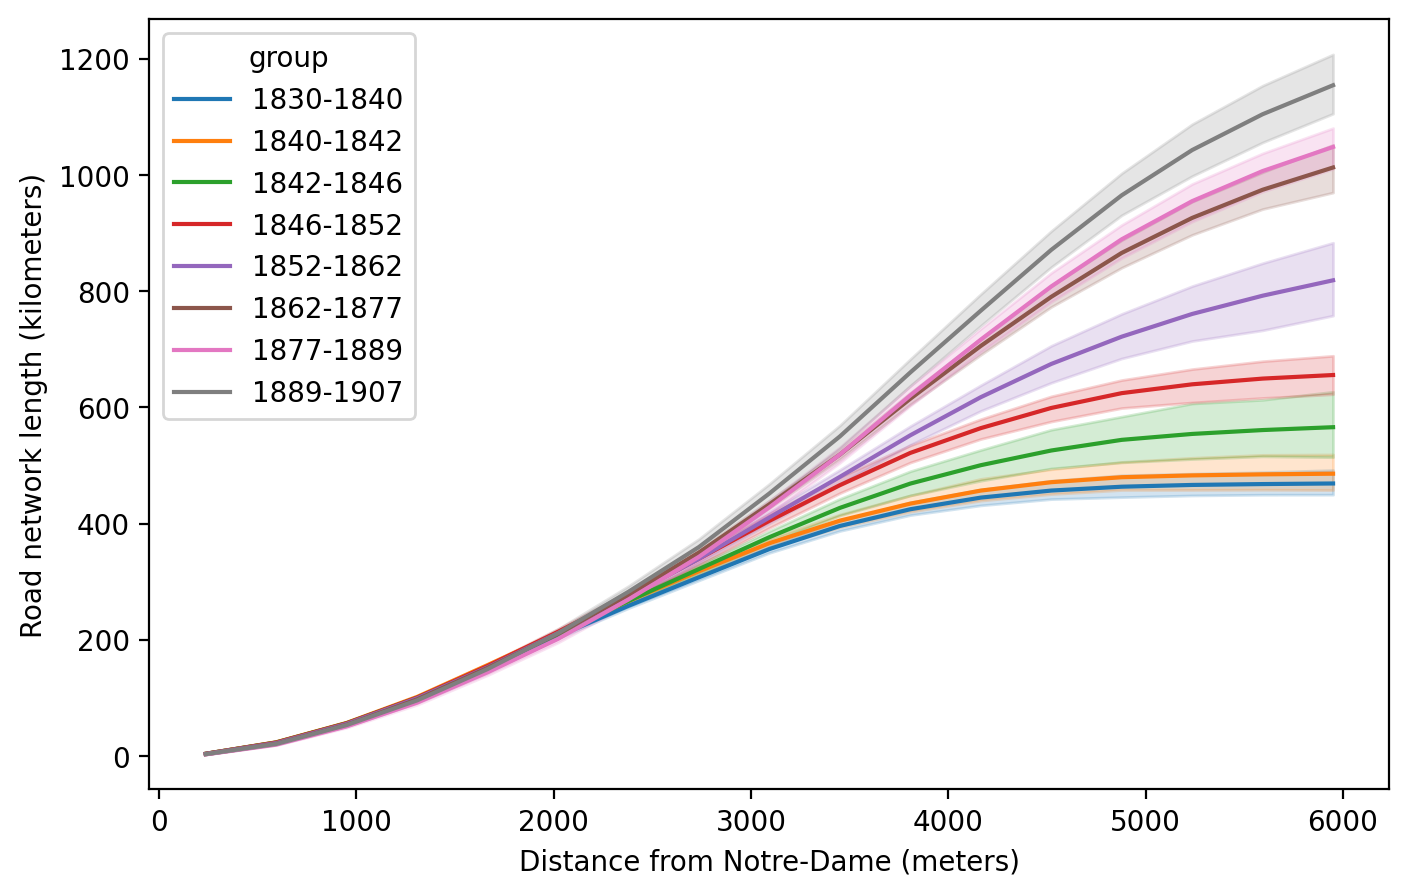

In [51]:
sns.reset_orig()
f, ax = plt.subplots(figsize=(8, 5), dpi=200)
palette = sns.color_palette("tab10", 8)
sns.lineplot(data=df[(df.group!=0) & (df.group!=9)], x="radius", y="km", hue="group", palette=palette, ax=ax)
ax.set_xlabel("Distance from Notre-Dame (meters)")
ax.set_ylabel("Road network length (kilometers)")

In [41]:
df.group = df.group.replace(to_replace="1830-1840", value=1)
df.group = df.group.replace(to_replace="1840-1842", value=2)
df.group = df.group.replace(to_replace="1842-1846", value=3)
df.group = df.group.replace(to_replace="1846-1852", value=4)
df.group = df.group.replace(to_replace="1852-1862", value=5)
df.group = df.group.replace(to_replace="1862-1877", value=6)
df.group = df.group.replace(to_replace="1877-1889", value=7)
df.group = df.group.replace(to_replace="1889-1907", value=8)

In [42]:
by_group = df.groupby(by=["group","radius"]).mean()
for i, row in by_group.iterrows():
    if row.name[0] > 0 and row.name[0] < 9:
        by_group.loc[i,"delta"] = row["km"] - by_group.loc[row.name[0]-1, row.name[1]]["km"]
    else:
        by_group.loc[i,"delta"] = -99999

In [43]:
only_take = by_group[by_group.delta > -99999].reset_index()

In [46]:
only_take.group = only_take.group.replace(to_replace=1, value="1830-1840")
only_take.group = only_take.group.replace(to_replace=2, value="1840-1842")
only_take.group = only_take.group.replace(to_replace=3, value="1842-1846")
only_take.group = only_take.group.replace(to_replace=4, value="1846-1852")
only_take.group = only_take.group.replace(to_replace=5, value="1852-1862")
only_take.group = only_take.group.replace(to_replace=6, value="1862-1877")
only_take.group = only_take.group.replace(to_replace=7, value="1877-1889")
only_take.group = only_take.group.replace(to_replace=8, value="1889-1907")

Text(0, 0.5, 'Augmentation of road network length (kilometers)')

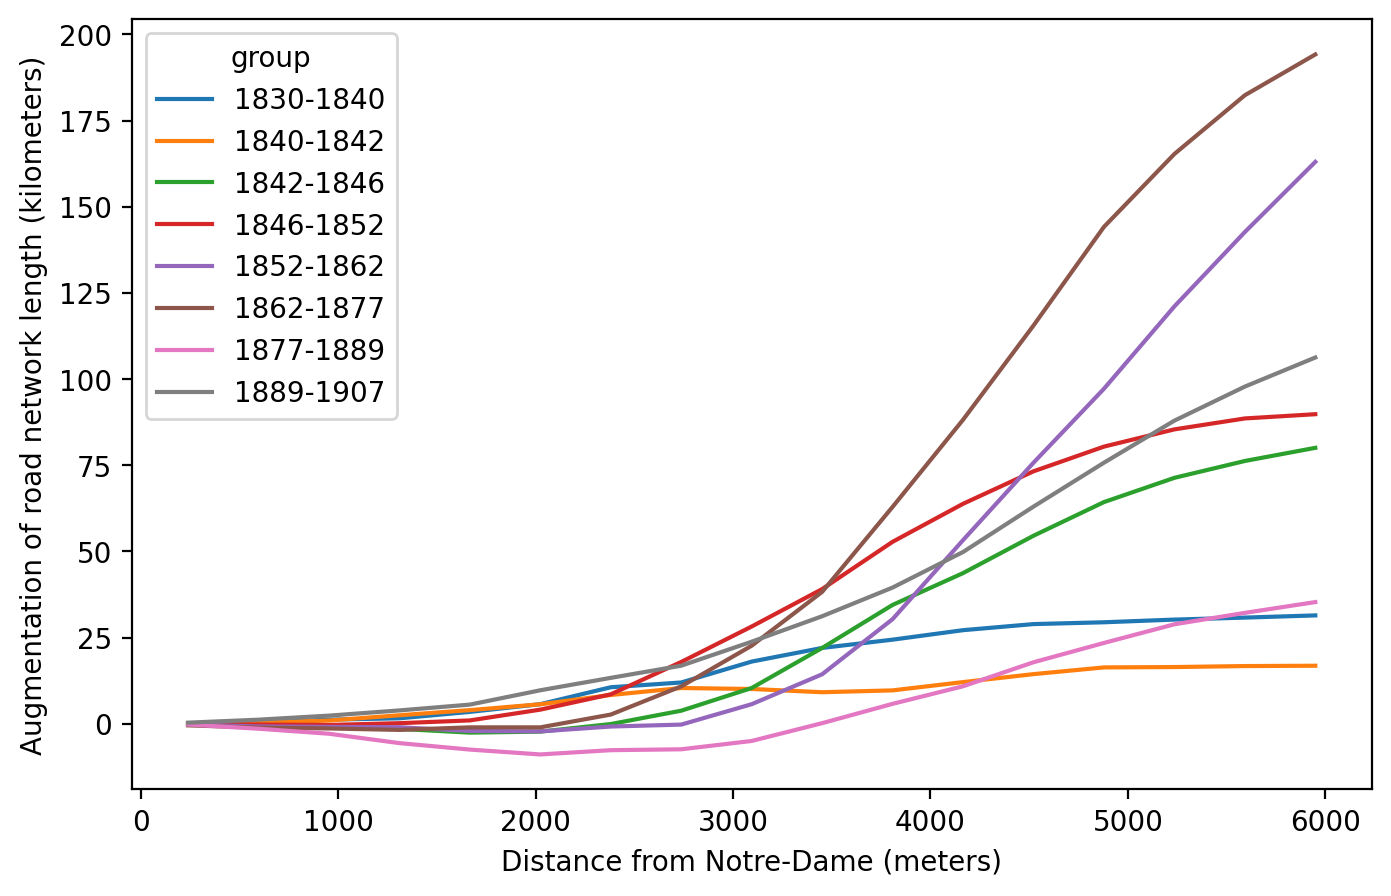

In [48]:
sns.reset_orig()
f, ax = plt.subplots(figsize=(8, 5), dpi=200)
palette = sns.color_palette("tab10", 8)
sns.lineplot(data=only_take, x="radius", y="delta", hue="group", ci=None, palette=palette, ax=ax)
ax.set_xlabel("Distance from Notre-Dame (meters)")
ax.set_ylabel("Augmentation of road network length (kilometers)")